## DEEP LEARNING COURSE
# GROUP 1 PROJECT [Semantic Segmentation]


In this project we used python codes from (https://github.com/Miaad2004/Unet-Based-Semantic-Segmentation-In-TensorFlow)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses
import tensorflow_datasets  as tfds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import random
from datetime import datetime
import itertools

In [ ]:
# Print the list of available devices
print(tf.config.experimental.list_physical_devices())

# Detect and Initialize the GPUs
strategy = tf.distribute.MirroredStrategy()
!nvidia-smi

print("GPUs initialized.")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tue Jul 25 15:34:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+--

# Hyperparameters

In [ ]:
N_REPLICAS = strategy.num_replicas_in_sync
print(f"Number of available replicas: {N_REPLICAS}")

IMAGE_SIZE = (128, 128)
EPOCHS = 40
BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * N_REPLICAS
EARLY_STOP_PATIENCE = 20

# Number of classes to segment the image to
N_CLASSES = 3

Number of available replicas: 1


In [ ]:
# Define the colormap for plotting the segmented images
COLORS = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]        # Red, Green, Blue
assert len(COLORS) == N_CLASSES
MASK_CMAP = matplotlib.colors.ListedColormap(COLORS)


# Helper Class


In [ ]:
class Helper:
    @staticmethod
    def resize(images, target_size):
        return tf.image.resize(images, target_size, method='bilinear')

    @staticmethod
    def augment(image, mask, probability=0.2):
        do_flip = tf.random.uniform(shape=[], minval=0, maxval=1, dtype=tf.float32) < probability

        if do_flip:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        return image, mask

    @staticmethod
    def preprocess(instance, target_size=IMAGE_SIZE, augment=False):
        image, mask = instance['image'], instance['segmentation_mask']

        # Resize the image
        image = Helper.resize(image, target_size)
        mask = Helper.resize(mask, target_size)

        # Augment the images randomly
        if augment:
            image, mask = Helper.augment(image, mask)

        # Normalize the images
        image = (tf.cast(image, tf.float32) - 127.5) / 127.5

        # Map classes 1, 2, 3 to classes 0, 1, 2
        mask = mask - 1

        return image, mask

    @staticmethod
    def plot(images, cmap=MASK_CMAP, titles=None, fig_size=(10, 10), is_BGR=True, n_cols=4):
        """
        This method allows you to display a collection of images in a grid, with titles for each image.

        Parameters:
        - `images` (list): A list of images.
        - `titles` (list, optional): A list of strings, representing the title for each image. The length of `titles` should be equal to the length of `images`.
        - `fig_size` (tuple): The size of the figure.
        - `is_BGR` (bool, optional): Indicates whether the input images are in BGR format (default is True).
        - `n_cols` (int, optional): The number of columns in the grid (default is 3).

        Returns:
        None
        """

        # Check if the images and the titles have the same length
        if titles is not None and len(images) != len(titles):
            raise ValueError("Images and titles must have the same length")

        # Calculate the number of rows required for the figure
        n_rows = int(np.ceil(len(images) / n_cols))

        # Create the fig
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=fig_size)

        for ax, img, title in itertools.zip_longest(axes.flat, images, titles or []):
            if is_BGR:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            ax.imshow(img, cmap=cmap)
            if titles is not None:
                ax.set_title(title)

            # Remove the tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        fig.tight_layout()



## IoU Metric :

References :
[1]https://www.programcreek.com/python/?CodeExample=compute+iou

[2] https://towardsdatascience.com/intersection-over-union-iou-calculation-for-evaluating-an-image-segmentation-model-8b22e2e84686


In [ ]:
import numpy as np

def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou



# Loading the Dataset
## ##  The Oxford-IIIT Pet Dataset [https://www.robots.ox.ac.uk/~vgg/data/pets/]

The dataset contains 37 category pet dataset with roughly 200 images for each class. The images have large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.

5


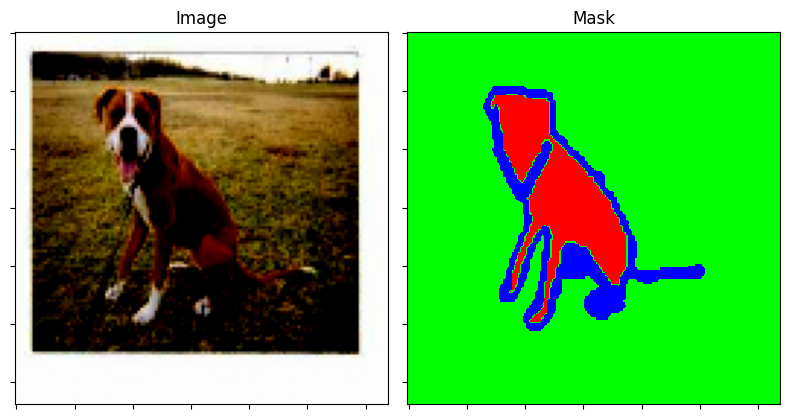

In [ ]:
# Load and split the Oxford-IIIT Pets dataset
(train_data, val_data, test_data), info = tfds.load("oxford_iiit_pet", split=["train[:70%]", "test[70%:80%]", "test[80%:]"], with_info=True)

# Preprocess
train_data = train_data.map(lambda i : Helper.preprocess(i, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(lambda i : Helper.preprocess(i, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(lambda i : Helper.preprocess(i, augment=False), num_parallel_calls=tf.data.AUTOTUNE)

# Convert to batched dataset
train_data = train_data.cache().batch(BATCH_SIZE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

val_data = val_data.cache().batch(BATCH_SIZE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)

test_data = test_data.cache().batch(BATCH_SIZE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

# Data Visualization

random_index = int(tf.random.uniform(shape=[], minval=1, maxval=BATCH_SIZE, dtype=tf.int32))
print(random_index)

batch = next(iter((train_data)))
image, mask = batch[0][random_index], batch[1][random_index]
Helper.plot([image, mask], cmap=MASK_CMAP, titles=['Image', 'Mask'], fig_size=(8,8), is_BGR=False, n_cols=2)


# Building the Model

### Model architecture based on https://arxiv.org/abs/1505.04597


In [ ]:
def downsample_block(inputs, filters, kernel_size=3, padding='same', strides=1):
    x = layers.Conv2D(filters, kernel_size, strides, padding, activation='relu', use_bias=False, kernel_initializer = "he_normal")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(filters, kernel_size, strides, padding, activation='relu', use_bias=False, kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    return x

def upsample_block(inputs, filters, skip_connection, kernel_size=3, padding='same', strides=1):
    x = layers.UpSampling2D()(inputs)
    x = layers.Concatenate(axis=-1)([x, skip_connection])

    x = layers.Conv2D(filters, kernel_size, strides, padding, activation='relu', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(filters, kernel_size, strides, padding, activation='relu', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    return x

def build_UNet(input_shape=(*IMAGE_SIZE, 3), n_output_channels=N_CLASSES):
    input_layer = layers.Input(shape=input_shape)

    # Encoder
    # 128 x 128 => 64 x 64
    down1 = downsample_block(inputs=input_layer, filters=64)
    pool1 = layers.MaxPooling2D((2, 2))(down1)

    # 64 x 64 => 32 x 32
    down2 = downsample_block(inputs=pool1, filters=128)
    pool2 = layers.MaxPooling2D((2, 2))(down2)

    # 32 x 32 => 16 x 16
    down3 = downsample_block(inputs=pool2, filters=256)
    pool3 = layers.MaxPooling2D((2, 2))(down3)

    # 16 x 16 => 8 x 8
    down4 = downsample_block(inputs=pool3, filters=512)
    pool4 = layers.MaxPooling2D((2, 2))(down4)

    # Final convolutional layer
    encoder_outputs = layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(pool4)

    # Decoder
    # 8 x 8 => 16 x 16
    up4 = upsample_block(inputs=pool4, filters=512, skip_connection=down4)

    # 16 x 16 => 32 x 32
    up3 = upsample_block(inputs=up4, filters=256, skip_connection=down3)

    # 32 x 32 => 64 x 64
    up2 = upsample_block(inputs=up3, filters=128, skip_connection=down2)

    # 64 x 64 => 128 x 128
    up1 = upsample_block(inputs=up2, filters=64, skip_connection=down1)

    # Output
    decoder_outputs = layers.Conv2D(n_output_channels, (1, 1), strides=1, activation='softmax')(up1)

    # Create the model
    model = keras.models.Model(inputs=[input_layer], outputs=[decoder_outputs], name="U-Net")

    return model


# Build and compile the model


In [ ]:
# Dice Loss (https://github.com/hubutui/DiceLoss-PyTorch/blob/master/loss.py)
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


def make_one_hot(input, num_classes):
    """Convert class index tensor to one hot encoding tensor.

    Args:
         input: A tensor of shape [N, 1, *]
         num_classes: An int of number of class
    Returns:
        A tensor of shape [N, num_classes, *]
    """
    shape = np.array(input.shape)
    shape[1] = num_classes
    shape = tuple(shape)
    result = torch.zeros(shape)
    result = result.scatter_(1, input.cpu(), 1)

    return result


class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))


class DiceLoss(nn.Module):
    """Dice loss, need one hot encode input
    Args:
        weight: An array of shape [num_classes,]
        ignore_index: class index to ignore
        predict: A tensor of shape [N, C, *]
        target: A tensor of same shape with predict
        other args pass to BinaryDiceLoss
    Return:
        same as BinaryDiceLoss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        predict = F.softmax(predict, dim=1)

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weights[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 128, 128, 64  1728        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_32 (BatchN  (None, 128, 128, 64  256        ['conv2d_36[0][0]']              
 ormalization)                  )                                                             

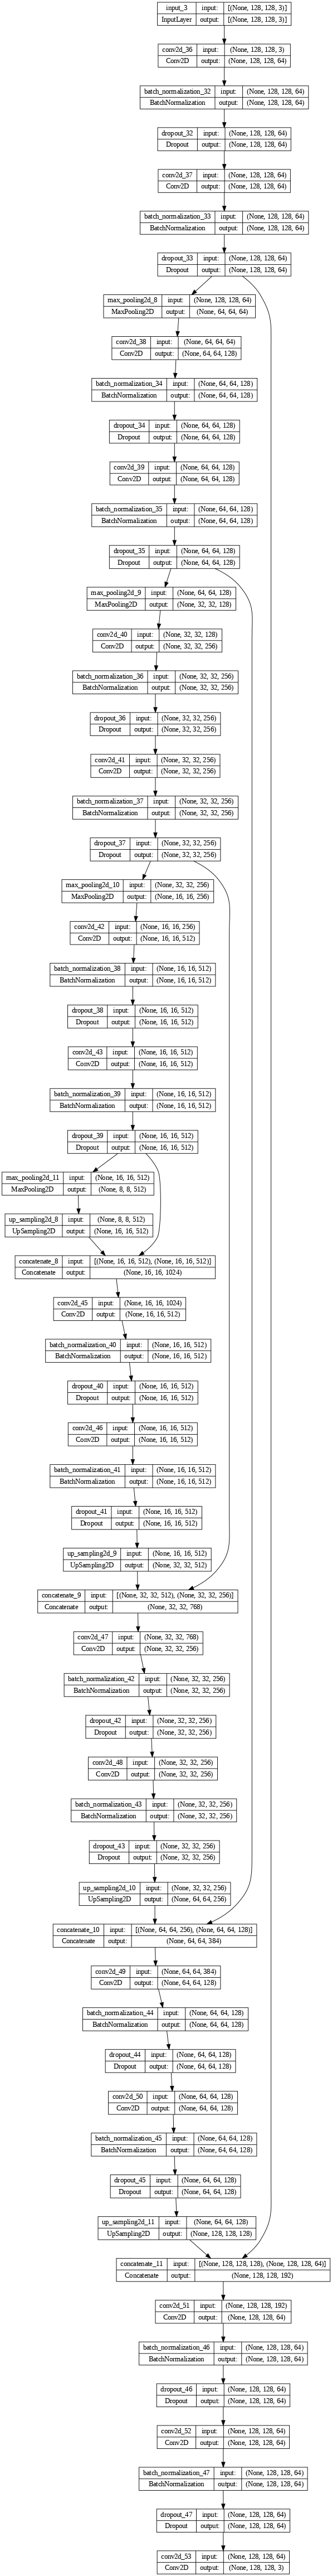

In [ ]:
learning_rate = 0.001
with strategy.scope():
    model = build_UNet(input_shape=(*IMAGE_SIZE, 3),
                       n_output_channels=N_CLASSES)

    model.compile(optimizer=optimizers.RMSprop(learning_rate=learning_rate),
              loss=[losses.SparseCategoricalCrossentropy(), losses.KLDivergence(), losses.Hinge(),DiceLoss],
              metrics='accuracy')
# Print the model's summary
model.summary()

# Plot the model's architecture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=65)


# Training

In [ ]:
# Stop training if the model doesn't improve for 7 epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=EARLY_STOP_PATIENCE,
                                              restore_best_weights=True,
                                              verbose=1
                                             )


In [ ]:
# Train the model
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=EPOCHS
                   )

Epoch 1/40
81/81 [==============================] - 68s 710ms/step - loss: 0.9065 - accuracy: 0.6143 - val_loss: 15.5539 - val_accuracy: 0.3175
Epoch 2/40
81/81 [==============================] - 46s 562ms/step - loss: 0.5796 - accuracy: 0.7639 - val_loss: 1.0072 - val_accuracy: 0.6932
Epoch 3/40
81/81 [==============================] - 47s 575ms/step - loss: 0.4821 - accuracy: 0.8023 - val_loss: 0.9716 - val_accuracy: 0.6969
Epoch 4/40
81/81 [==============================] - 47s 578ms/step - loss: 0.4343 - accuracy: 0.8214 - val_loss: 1.0787 - val_accuracy: 0.6775
Epoch 5/40
81/81 [==============================] - 47s 579ms/step - loss: 0.4055 - accuracy: 0.8325 - val_loss: 0.8562 - val_accuracy: 0.7347
Epoch 6/40
81/81 [==============================] - 46s 574ms/step - loss: 0.3773 - accuracy: 0.8445 - val_loss: 0.8651 - val_accuracy: 0.7292
Epoch 7/40
81/81 [==============================] - 47s 577ms/step - loss: 0.3539 - accuracy: 0.8543 - val_loss: 0.8740 - val_accuracy: 0.755

In [ ]:
# Save the model
model.save(f"{datetime.now().strftime('%Y%m%d-%H%M%S')}-UNet.h5")

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data)
# Example usage:
segmentations = model.predict(test_data)
iou_score = calculate_iou(mask, segmentations)
# Print the results

print(f"IoU: {iou_score}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

23/23 [==============================] - 4s 127ms/step
IoU: 0.3195529304056596
Test Loss: 1.2467726469039917
Test Accuracy: 0.791802167892456


# Evaluation

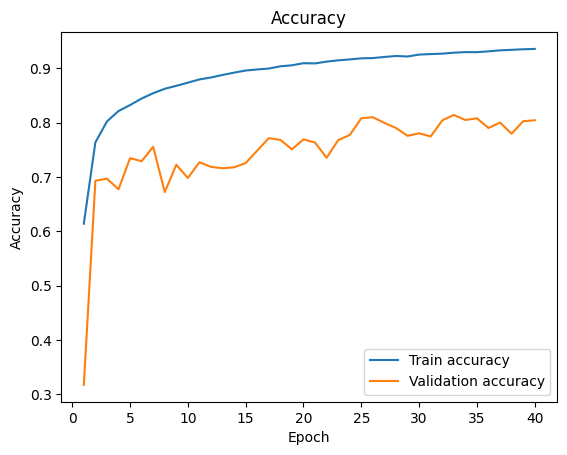

In [ ]:
# Plot the accuracy curve
plt.plot(range(1, len(history.history['accuracy']) + 1),
         history.history['accuracy'],
         label="Train accuracy"
        )
plt.plot(range(1, len(history.history['val_accuracy']) + 1),
         history.history['val_accuracy'],
         label="Validation accuracy"
        )

plt.title("Accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

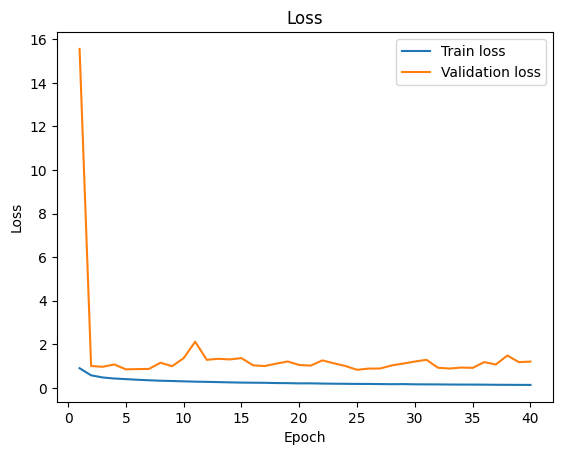

In [ ]:
# Plot the loss curve
plt.plot(range(1, len(history.history['loss']) + 1),
         history.history['loss'],
         label="Train loss"
        )
plt.plot(range(1, len(history.history['val_loss']) + 1),
         history.history['val_loss'],
         label="Validation loss"
        )

plt.title("Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

1/1 [==============================] - 0s 76ms/step


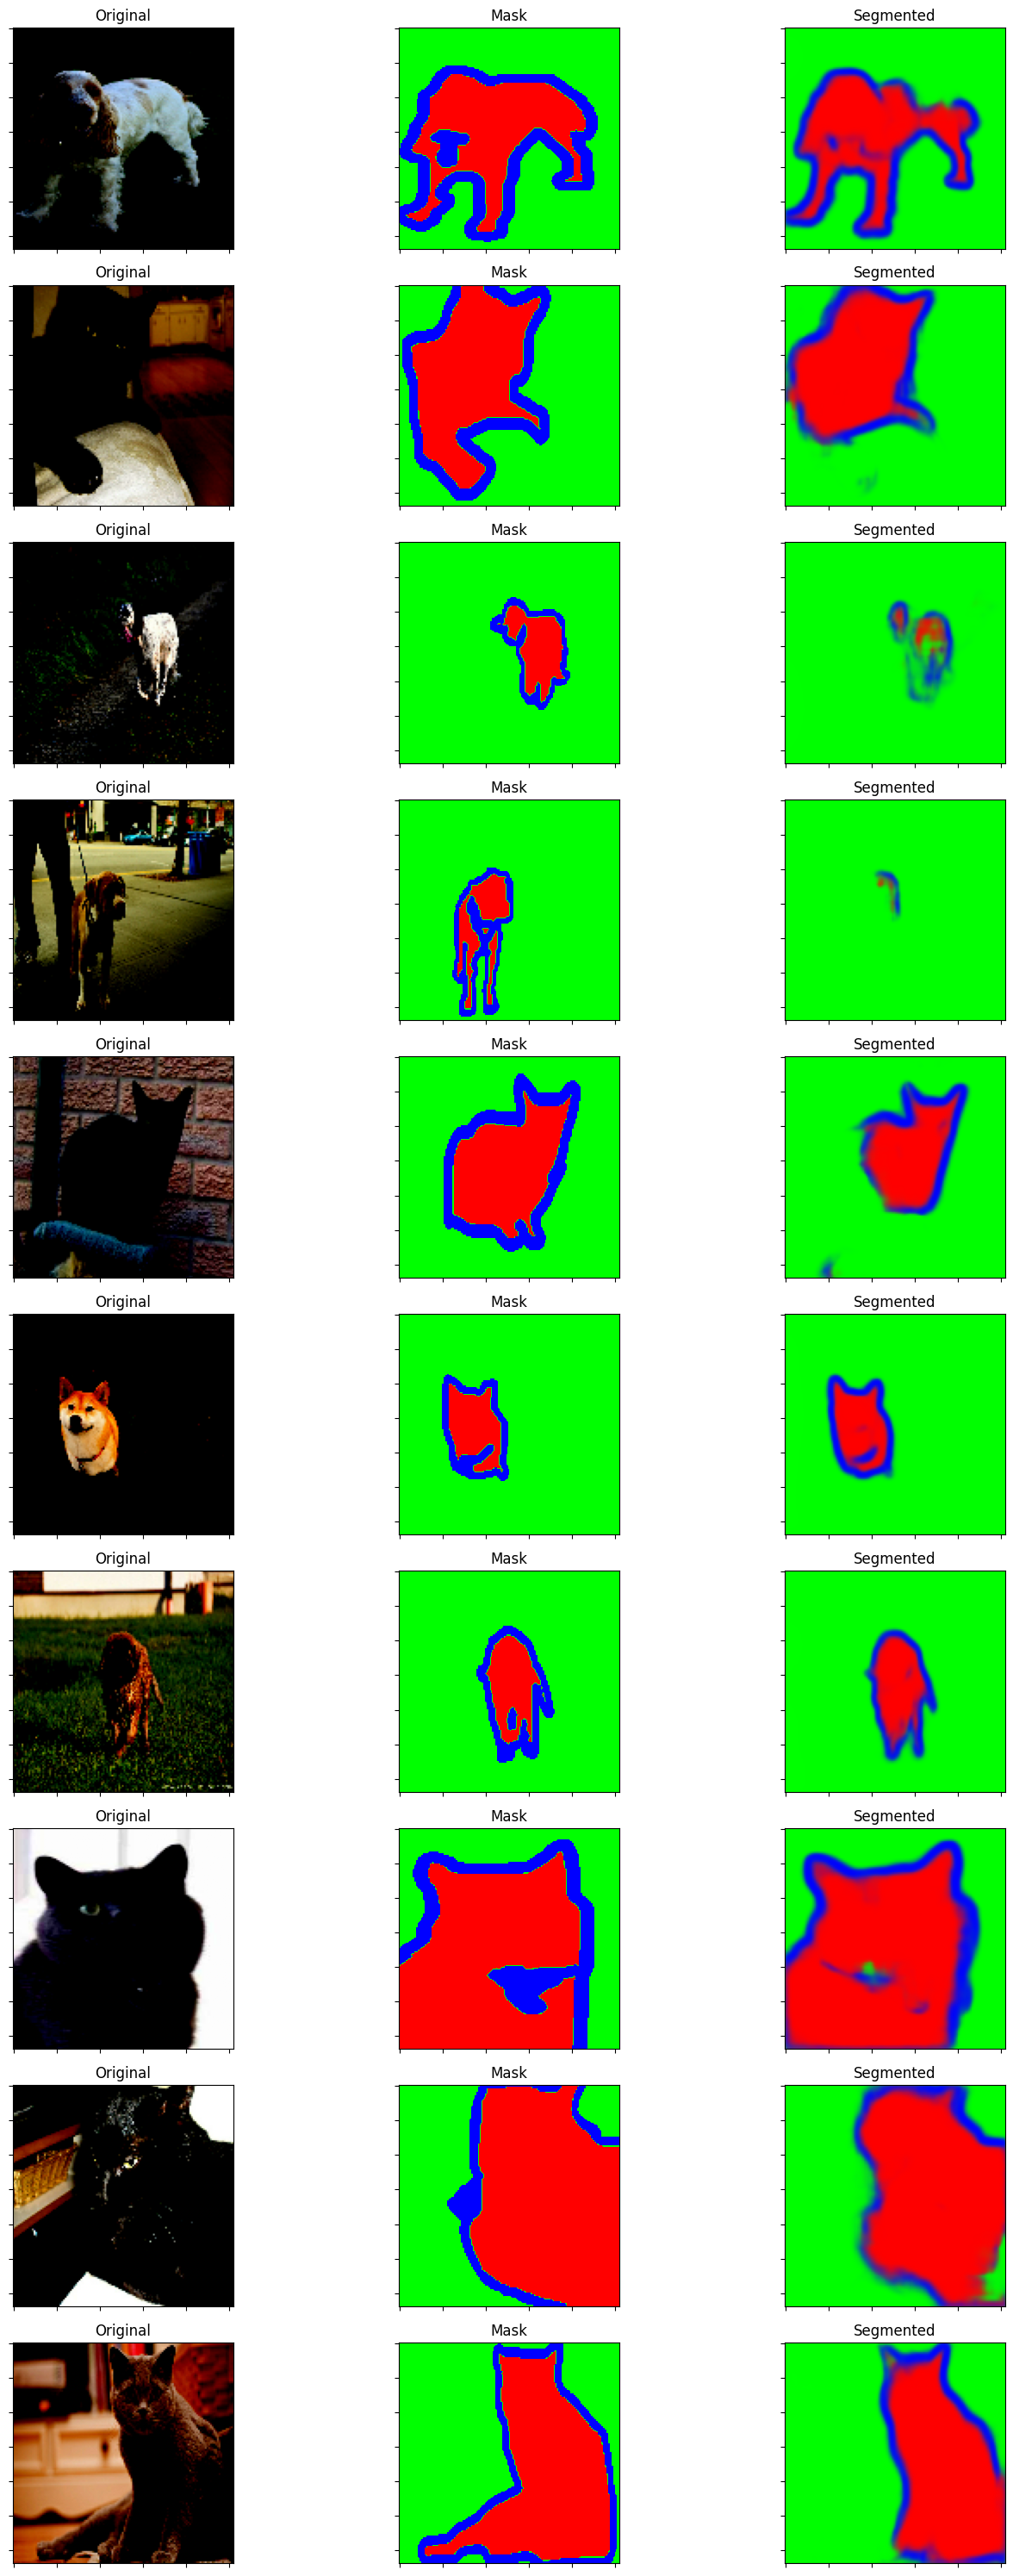

In [ ]:
n_tests = 10

# Select a random batch
batch = next(iter(test_data.shuffle(1000)))

# Select 'n_tests' images to segment
images, masks = batch[0], batch[1]
images, masks = images[: n_tests], masks[: n_tests]

# Segment the selected images
segmentations = model.predict(images)

# Plot the segmented images
to_plot = []
titles = []
for image, mask, segmented in zip(images, masks, segmentations):
    to_plot.append(image)
    to_plot.append(mask)
    to_plot.append(segmented)

    titles.append('Original')
    titles.append('Mask')
    titles.append('Segmented')

Helper.plot(to_plot, titles=titles, cmap=MASK_CMAP, n_cols=3, is_BGR=False, fig_size=(15, 30))

## Transfering  model on Oxford 102 flower dataset :

Ref :  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

# Download the Oxford Flower dataset
dataset, info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True)

# Split the dataset into train, validation, and test sets
num_examples = info.splits['train'].num_examples
num_train = int(0.7 * num_examples)
num_val = int(0.1 * num_examples)

train_data = dataset['train'].take(num_train)
val_data = dataset['train'].skip(num_train).take(num_val)
test_data = dataset['test'].skip(num_train + num_val)

# Define batch size and any additional preprocessing
batch_size = 32
image_size = (128, 128)

# Preprocess the images and labels
def preprocess_image(image, label):
    image = tf.image.resize(image, image_size)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

train_data = train_data.map(preprocess_image).batch(batch_size)
val_data = val_data.map(preprocess_image).batch(batch_size)
test_data = test_data.map(preprocess_image).batch(batch_size)

# Iterate over the train_data and apply the trained model on each batch
for images, labels in train_data:
    outputs = model.predict(images)  # Perform a forward pass on each batch of images


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 74ms/step


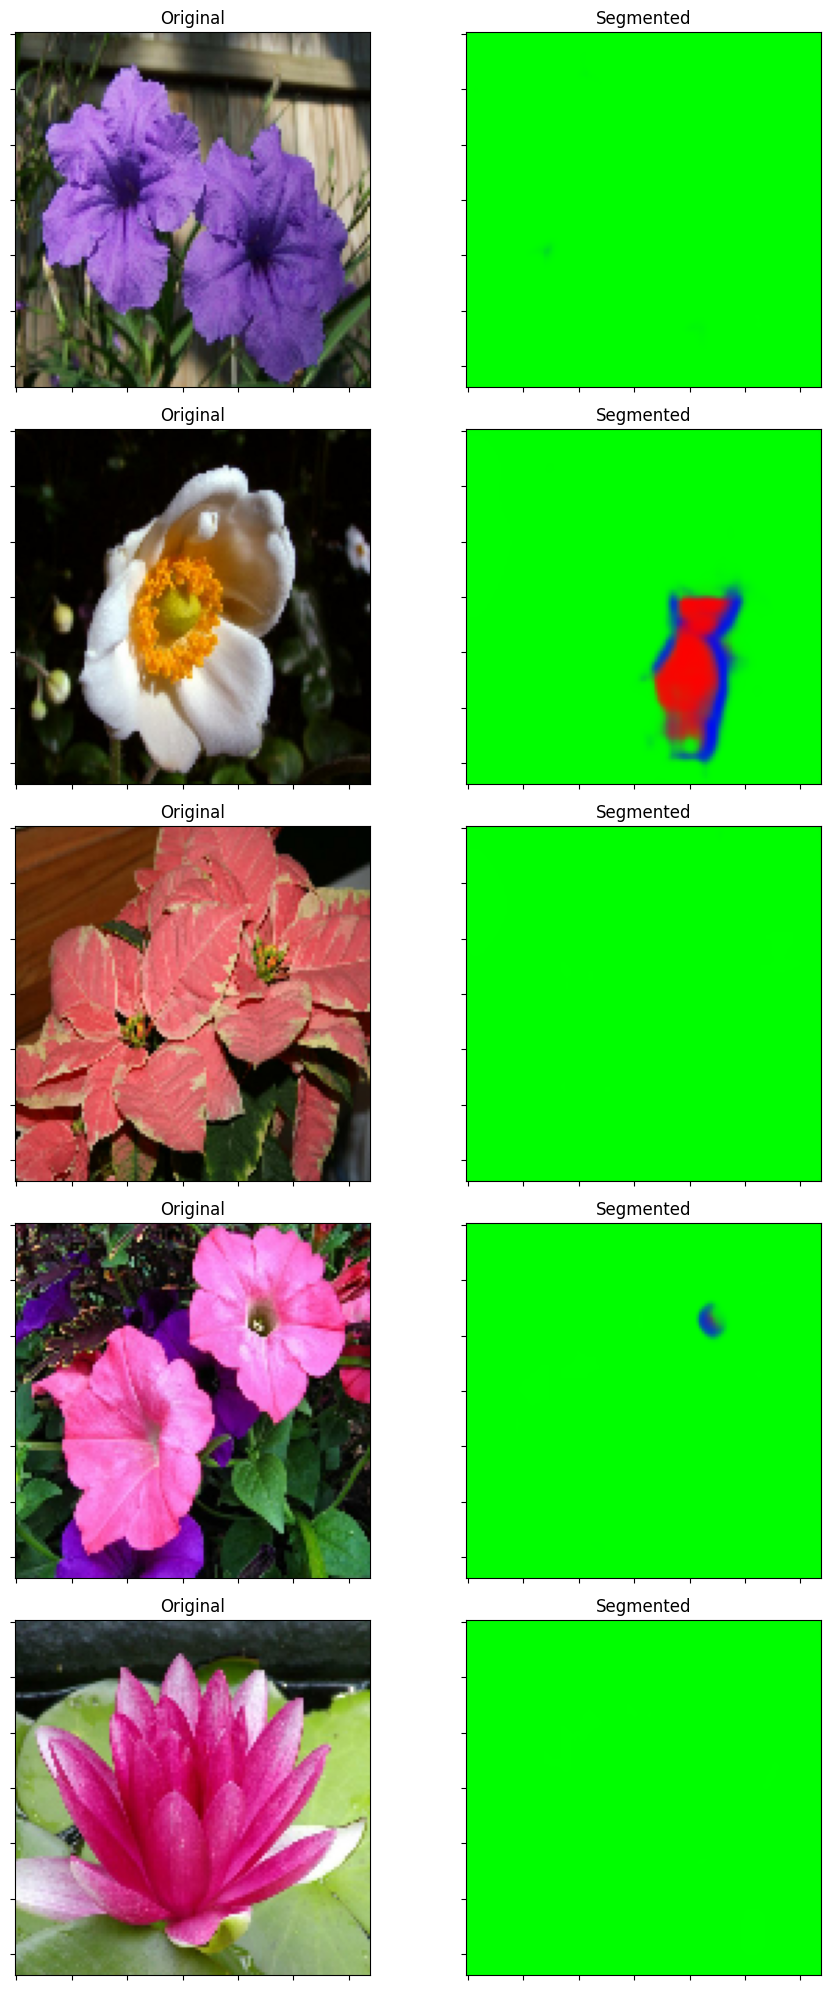

In [ ]:
n_tests = 5

# Select a random batch
batch = next(iter(test_data.shuffle(1000)))

# Select 'n_tests' images to segment
images = batch[0]
images = images[: n_tests]

# Segment the selected images
segmentations = model.predict(images)

# Plot the segmented images
to_plot = []
titles = []
for image, segmented in zip(images,segmentations):
    to_plot.append(image)
    to_plot.append(segmented)

    titles.append('Original')
    titles.append('Segmented')

Helper.plot(to_plot, titles=titles, cmap=MASK_CMAP, n_cols=2, is_BGR=False, fig_size=(10, 20))